In [1]:
import math
import torch
from diffusion_edf.dist import sample_igso3

from matplotlib import pyplot as plt

import numpy as np
np.set_printoptions(precision=4, floatmode="fixed")

In [2]:
sample_w_max = sample_igso3(eps=100., N=100000)
sample_w_max = torch.acos(sample_w_max[:,0])*2
sample_w_degree_max = sample_w_max / torch.pi * 180.

$IG_{SO(3)}$ almost converges at $t=6$

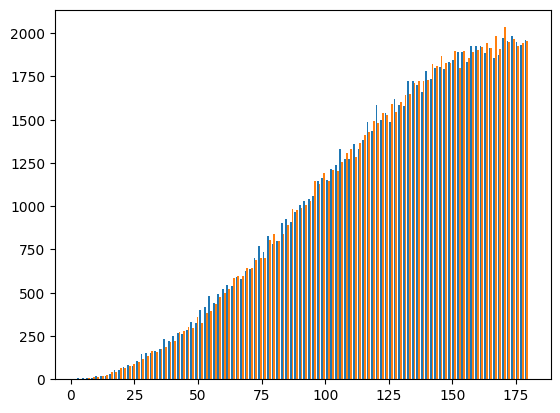

In [3]:
t = 6.
eps = t/2

sample = sample_igso3(eps=eps, N=100000)
sample_w = torch.acos(sample[:,0])*2
sample_w_degree = sample_w / torch.pi * 180.

plt.hist([sample_w_degree, sample_w_degree_max], bins=100)
plt.show()

$\textrm{rotation angle}\ \  w\approx \sqrt{t}\times 38.5\degree$

In [4]:
for t in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    eps = t/2

    sample = sample_igso3(eps=eps, N=100000)
    sample_w = torch.acos(sample[:,0])*2
    sample_w_degree = sample_w / torch.pi * 180.
    print(sample_w.std().item() / math.sqrt(t))
print(f"\n degree: {sample_w_degree.std().item() / math.sqrt(t)}")

0.6729536310759507
0.6724601953674686
0.6733644924815594
0.6748430440364143
0.6744501029228603

 degree: 38.643144389643915


# Play

tensor(3.8549, dtype=torch.float64)


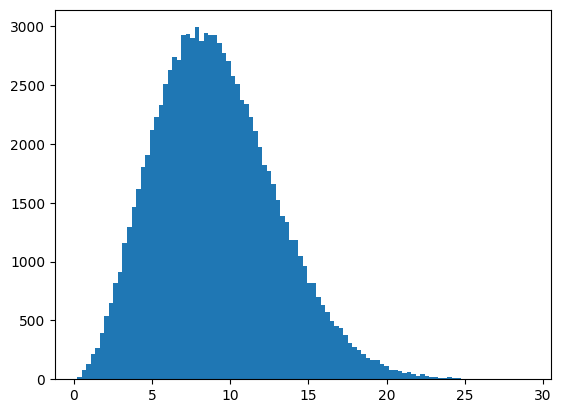

In [5]:
t = 1e-2
eps = t/2

sample = sample_igso3(eps=eps, N=100000)
sample_w = torch.acos(sample[:,0])*2
sample_w_degree = sample_w / torch.pi * 180.
print(sample_w_degree.std())

plt.hist(sample_w_degree, bins=100)
plt.show()

# Calculator

In [6]:
def std_calculator(t_schedule, lin_mult, ang_mult = 1., p = 0.95, N = 100000):
    lin_stds = []
    ang_stds = []
    lin_maxs = []
    ang_maxs = []
    lin_meds = []
    ang_meds = []
    lin_mods = []
    ang_mods = []

    for t in t_schedule:
        eps = t/2 * (ang_mult**2)
        std = torch.tensor([math.sqrt(t*3)]) * lin_mult
        lin_stds.append(std)
        lin_samples = torch.randn(N,3).norm(dim=-1) * std

        sample = sample_igso3(eps=eps, N=N)
        sample_w = torch.acos(sample[:,0])*2
        sample_w_degree = sample_w / torch.pi * 180.
        ang_stds.append(sample_w_degree.std().unsqueeze(0))
        ang_max = sample_w_degree.sort().values[int(p*N)]
        ang_maxs.append(ang_max.unsqueeze(0))
        lin_max = lin_samples.sort().values[int(p*N)]
        lin_maxs.append(lin_max.unsqueeze(0))

        lin_meds.append(lin_samples.median().unsqueeze(0))
        ang_meds.append(sample_w_degree.median().unsqueeze(0))

        boundaries = torch.linspace(0., ang_max*1.2, steps=100)
        bins = torch.bucketize(sample_w_degree, boundaries=boundaries)
        ang_mod = boundaries[bins.mode().values]

        boundaries = torch.linspace(0., lin_max*1.2, steps=100)
        bins = torch.bucketize(lin_samples, boundaries=boundaries)
        lin_mod = boundaries[bins.mode().values]

        lin_mods.append(lin_mod.unsqueeze(0))
        ang_mods.append(ang_mod.unsqueeze(0))

    return torch.cat(lin_stds), torch.cat(ang_stds), torch.cat(lin_maxs), torch.cat(ang_maxs), torch.cat(lin_meds), torch.cat(ang_meds), torch.cat(lin_mods), torch.cat(ang_mods)

In [7]:
lin_stds, ang_stds, lin_maxs, ang_maxs, lin_meds, ang_meds, lin_mods, ang_mods = std_calculator([1e-4, 1e-3, 1e-2, 1e-1, 1.], ang_mult = 2.5, lin_mult=20., p=0.95)

print(f"angular std: {ang_stds.numpy()}")
print(f"angular median: {ang_meds.numpy()}")
print(f"angular mode: {ang_mods.numpy()}")
print(f"angular max: {ang_maxs.numpy()}")
print("========================================")
print(f"linear std: {lin_stds.numpy()}")
print(f"linear median: {lin_meds.numpy()}")
print(f"linear mode: {lin_mods.numpy()}")
print(f"linear max: {lin_maxs.numpy()}")

angular std: [ 0.9651  3.0433  9.6416 29.5974 37.1521]
angular median: [  2.1970   6.9405  21.9110  67.6567 132.4273]
angular mode: [  2.1315   7.0423  19.3873  62.6036 178.6676]
angular max: [  3.9967  12.6303  39.9862 122.9713 175.4771]
linear std: [ 0.3464  1.0954  3.4641 10.9545 34.6410]
linear median: [ 0.5333  1.6847  5.3183 16.8396 53.4573]
linear mode: [ 0.4941  1.5151  4.8052 15.6154 50.6773]
linear max: [ 0.9706  3.0487  9.6689 30.6731 97.2297]


In [8]:
lin_stds, ang_stds, lin_maxs, ang_maxs, lin_meds, ang_meds, lin_mods, ang_mods = std_calculator([1e-4, 5e-4, 5e-3, 3e-2, 1e-1, 1.], ang_mult = 2.5, lin_mult=15., p=0.95)

print(f"angular std: {ang_stds.numpy()}")
print(f"angular median: {ang_meds.numpy()}")
print(f"angular mode: {ang_mods.numpy()}")
print(f"angular max: {ang_maxs.numpy()}")
print("========================================")
print(f"linear std: {lin_stds.numpy()}")
print(f"linear median: {lin_meds.numpy()}")
print(f"linear mode: {lin_mods.numpy()}")
print(f"linear max: {lin_maxs.numpy()}")

angular std: [ 0.9681  2.1628  6.7990 16.5959 29.4584 37.0531]
angular median: [  2.1985   4.9211  15.5213  37.8161  67.9582 132.3020]
angular mode: [  2.1371   4.3370  15.3756  31.6961  59.5371 176.6402]
angular max: [  4.0071   8.9451  28.1886  68.8140 122.7953 175.5761]
linear std: [ 0.2598  0.5809  1.8371  4.5000  8.2158 25.9808]
linear median: [ 0.4000  0.8940  2.8288  6.9112 12.6368 39.9268]
linear mode: [ 0.3431  0.8070  2.6225  6.5609 12.5459 40.4939]
linear max: [ 0.7259  1.6238  5.1513 12.5878 23.0008 72.6250]


In [9]:
lin_stds, ang_stds, lin_maxs, ang_maxs, lin_meds, ang_meds, lin_mods, ang_mods = std_calculator([0.003, 0.03, 0.1], ang_mult = 2.5, lin_mult=15., p=0.95)

print(f"angular std: {ang_stds.numpy()}")
print(f"angular median: {ang_meds.numpy()}")
print(f"angular mode: {ang_mods.numpy()}")
print(f"angular max: {ang_maxs.numpy()}")
print("========================================")
print(f"linear std: {lin_stds.numpy()}")
print(f"linear median: {lin_meds.numpy()}")
print(f"linear mode: {lin_mods.numpy()}")
print(f"linear max: {lin_maxs.numpy()}")

angular std: [ 5.2752 16.5873 29.6404]
angular median: [12.0600 37.9163 67.6430]
angular mode: [11.1311 36.0137 62.5563]
angular max: [ 21.8646  69.0960 122.8784]
linear std: [1.4230 4.5000 8.2158]
linear median: [ 2.1909  6.9436 12.6353]
linear mode: [ 1.9369  6.8586 10.8663]
linear max: [ 3.9949 12.5740 22.9864]
